<h1>Cyberbullying detection</h1>
<hr>
<h2>Text Classification NPL<h2>
<h3>Proyect 7</h3>
<hr>
<h3>EDA</h3>
<hr>

In [8]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

import gensim
import wordcloud
import spacy
import textstat

from nltk.corpus import stopwords
from collections import  Counter
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from utilerias import missing_values_table
from utilerias import features_by_type

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<hr>
read the dataset
<hr>

In [3]:
df_cbd = pd.read_csv('../datasets/twitter_parsed_dataset.csv')

In [4]:
df_cbd.head()

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [5]:
#let's standarize some features, before to proceed with the EDA
#Eliminate spaces and upper cases from name columns
df_cbd.columns=df_cbd.columns.str.lower().str.replace(' ', '_')


In [6]:
df_cbd.columns

Index(['index', 'id', 'text', 'annotation', 'oh_label'], dtype='object')

In [9]:
table = missing_values_table(df_cbd)
table.style.background_gradient(cmap='Reds')

Sumary :
Columns     :5
Null values :4


,Missing Values,% of Total Values
annotation,3,0.000000
oh_label,3,0.000000
id,1,0.000000
text,1,0.000000


In [10]:
df_cbd[df_cbd['id'].isnull() | df_cbd['text'].isnull() | df_cbd['annotation'].isnull()] 

,index,id,text,annotation,oh_label
2992,5.67909969783169E+017,5.67909969783169E+017,RT @Lizzethismetal: Probably gonna piss off so...,NaN,NaN
2993,#yesallmen,NaN,NaN,NaN,NaN
2994,@MT8_9 http://t.co/QHo6dhumjc,sexism,1,NaN,NaN


There are 3 rows with some missing features values, I will consider to delete them

take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.

<AxesSubplot:>

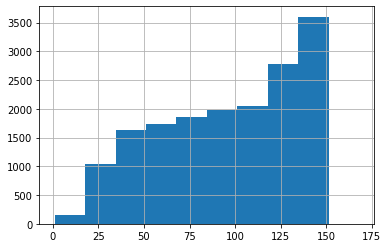

In [11]:
df_cbd['text'].str.len().hist()

Now, let’s plot the number of words appearing in each tweet.

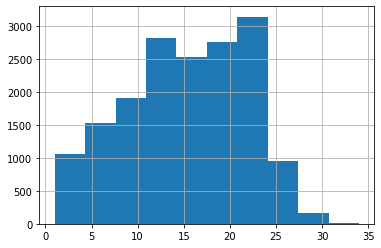

In [12]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
    
plot_word_number_histogram(df_cbd[~df_cbd['text'].isnull()]['text'])

let's take a look of the average lenght word in those tweets

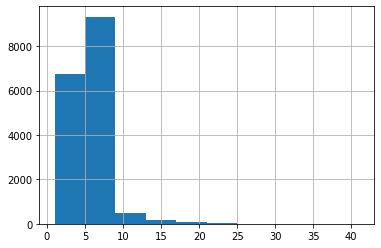

In [14]:
def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()

plot_word_length_histogram(df_cbd[~df_cbd['text'].isnull()]['text'])

Seems to be 5-6 the average word lenght, but I have to consider the stopwords in every text

In [11]:
#download the stopwords from nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hmorales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
#create an array of english stopwords
stop=set(stopwords.words('english'))

what are the included stopwords in the tweets? here is how I know it: the 10 most frecuent used stopwords

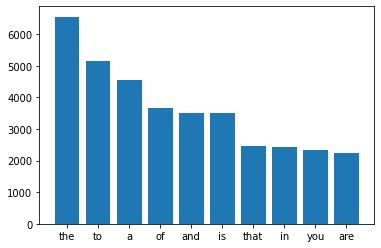

In [16]:
#create a bar plot  to show the stopwords
def plot_top_stopwords_barchart(text):
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)


plot_top_stopwords_barchart(df_cbd[~df_cbd['text'].isnull()]['text'])

Here are the most frecuent used words, of course not stopwords

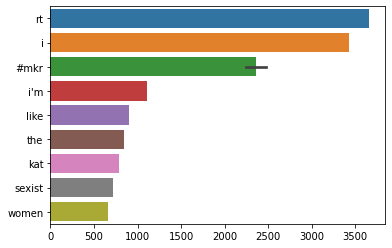

In [17]:
def plot_top_non_stopwords_barchart(text):
        
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word.lower())
            y.append(count)
            
    sns.barplot(x=y,y=x)
[5]
plot_top_non_stopwords_barchart(df_cbd[~df_cbd['text'].isnull()]['text'])

Lets see how many different notes are in the data set for every value in target variable

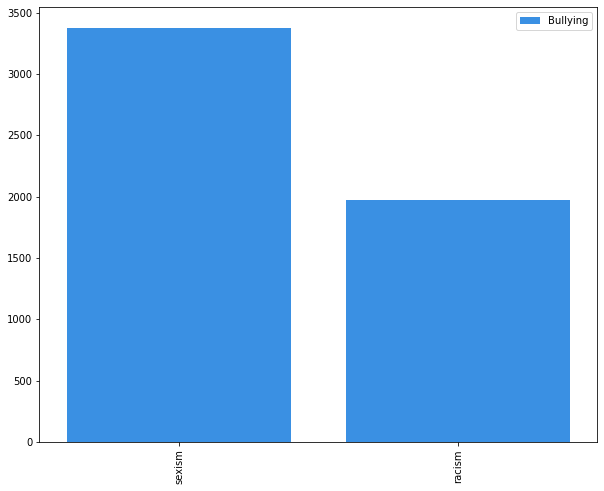

In [18]:
plt.figure(figsize=(10,8))
df_bullyied = df_cbd.loc[df_cbd['oh_label'] == 1.0]
sns.barplot(data=df_bullyied,x = df_bullyied['annotation'].unique(),y = df_bullyied['annotation'].value_counts().values,color='dodgerblue', label="Bullying")
plt.xticks(rotation=90)
plt.legend()
plt.show()

<h3>Topic modeling exploration with pyLDAvis</h3>
<p>Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.</p>

<p>Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.</p>

<p>Once we categorize our documents in topics we can dig into further data exploration for each topic or topic group.</p>

In [19]:
def get_lda_objects(text):
    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [20]:
lda_model, bow_corpus, dic = get_lda_objects(df_cbd[~df_cbd['text'].isnull()]['text'])

In [21]:
lda_model.show_topics()

[(0,
  '0.043*"MKR" + 0.037*"mkr" + 0.017*"Kat" + 0.015*"n\'t" + 0.010*"http" + 0.009*"amp" + 0.008*"Andre" + 0.007*"..." + 0.006*"girl" + 0.005*"would"'),
 (1,
  '0.026*"http" + 0.016*"Islam" + 0.013*"n\'t" + 0.008*"Muslims" + 0.008*"woman" + 0.008*"The" + 0.006*"like" + 0.006*"You" + 0.005*"Muslim" + 0.005*"And"'),
 (2,
  '0.019*"http" + 0.008*"ISIS" + 0.004*"And" + 0.004*"Daesh" + 0.004*"Mosul" + 0.004*"The" + 0.004*"halalflaws" + 0.003*"say" + 0.003*"greenlinerzjm" + 0.003*"people"'),
 (3,
  '0.020*"sexist" + 0.019*"n\'t" + 0.013*"..." + 0.013*"woman" + 0.007*"like" + 0.007*"mkr" + 0.006*"http" + 0.005*"female" + 0.005*"people" + 0.004*"think"')]

In [22]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.177936  0.033095       1        1  30.064075
1     -0.086860 -0.157955       2        1  29.602091
3      0.054734 -0.006995       3        1  22.632207
2     -0.145811  0.131854       4        1  17.701628, topic_info=       Term         Freq        Total Category  logprob  loglift
63      MKR  2188.000000  2188.000000  Default  30.0000  30.0000
42      mkr  2103.000000  2103.000000  Default  29.0000  29.0000
155     Kat   857.000000   857.000000  Default  28.0000  28.0000
32   sexist   918.000000   918.000000  Default  27.0000  27.0000
538   Islam   779.000000   779.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
263    sure    50.414141   148.587614   Topic4  -6.3292   0.6506
135    like    68.005992   806.169977   Topic4  -6.0299  -0.7412
160     one    51.736368   523.406297   Topic4  -6.3033  -0.5827
153     ...    49.258666   925.596220   Topic4  -6.3524  -1.2018
771   right    47.543683   249.055932   Topic4  -6.3878   0.0755

[289 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1566      1  0.841004    'll
1566      2  0.005721    'll
1566      3  0.148749    'll
130       1  0.374678    're
130       2  0.265078    're
...     ...       ...    ...
165       4  0.090917  would
187       1  0.129548   year
187       2  0.708195   year
187       3  0.073411   year
187       4  0.095002   year

[444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

Let's get a wordcloud

In [23]:
def plot_wordcloud(text):
    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

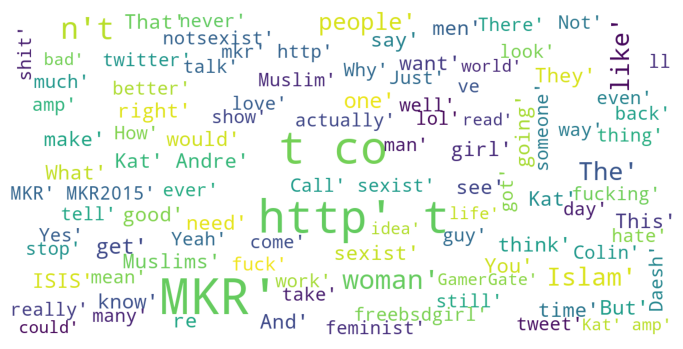

In [24]:
plot_wordcloud(df_cbd[~df_cbd['text'].isnull()]['text'])

<h3>Sentiment analysis</h3>

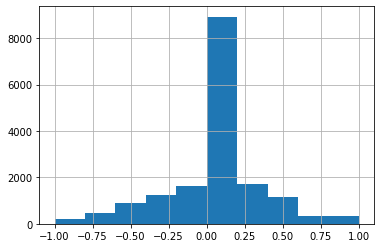

In [22]:
# visualize sentiments using a histogram and explore data even further.
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    polarity_score.hist()

plot_polarity_histogram(df_cbd[~df_cbd['text'].isnull()]['text'])

 The polarity mainly ranges between 0.00 and 0.20. This indicates that the majority of the tweets are neutral.

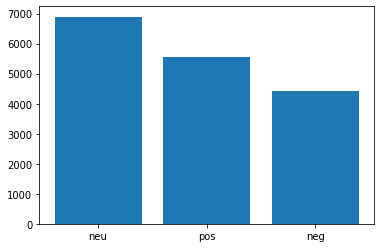

In [25]:
def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,sentiment.value_counts())

plot_sentiment_barchart(df_cbd[~df_cbd['text'].isnull()]['text'], method='TextBlob')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hmorales\AppData\Roaming\nltk_data...


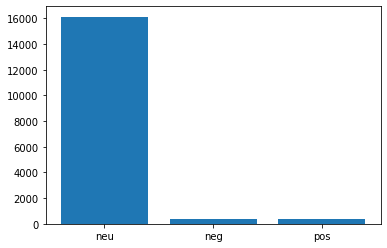

In [26]:

plot_sentiment_barchart(df_cbd[~df_cbd['text'].isnull()]['text'], method='Vader')

<hr>
save the data set
<hr>

In [28]:
df_cbd.to_csv('../datasets/twitter_parsed_dataset_post_EDA.csv',index=False)